# -- Import libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import io
import time

# -- Folder structure and Model library
Name and url of the model downloaded form TF2 Model zoo:
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
Get the link by copying the link for the model that you want to train from the model zoo
Note that if you changed the model you HAVE TO CHANGE BOTH OF THE FOLLOWINGS

In [2]:
CUSTOM_MODEL_NAME = 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8'
PRETRAINED_MODEL_NAME = 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz'

LABEL_MAP_NAME = 'label_map.pbtxt'

root_dir = "Project"
work_dir = "data_models"
tf_m = 'pre_trained_models'
my_tf_m = 'my_trained_models'

paths = {
    'WORKSPACE_PATH': os.path.join(root_dir, work_dir),
    'APIMODEL_PATH': os.path.join(root_dir,'tf_model_garden'),
    'ANNOTATION_PATH': os.path.join(root_dir, work_dir,'annot'),
    'IMAGE_PATH': os.path.join(root_dir, work_dir,'images'),
    'MODEL_PATH': os.path.join(root_dir, work_dir,my_tf_m),
    'PRETRAINED_MODEL_PATH': os.path.join(root_dir, work_dir,tf_m),
    'CHECKPOINT_PATH': os.path.join(root_dir, work_dir,my_tf_m,CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join(root_dir, work_dir,my_tf_m,CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join(root_dir, work_dir,my_tf_m,CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join(root_dir, work_dir,my_tf_m,CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH':os.path.join(root_dir,'protoc')
 }


files = {
    'PIPELINE_CONFIG':os.path.join(root_dir, work_dir,my_tf_m, CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

for path in paths.values():
    if not os.path.exists(path):
        os.makedirs(path)


#-- Upload images
Now upload your images (zip file) into the "images" directory

#-- Download the TF model garden and install OD API


In [9]:
if os.name=='nt':
    !pip install wget
    import wget

if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

# Install Tensorflow Object Detection -------------------------------------------------------------------------------------------
# if os.name=='posix':  
#     !apt-get install protobuf-compiler
#     !cd Project/tf_model_garden/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 

# if os.name=='nt':
#     url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
#     wget.download(url)
#     !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
#     !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
#     os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
#     !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
#     !cd Tensorflow/models/research/slim && pip install -e . 


Cloning into 'Project\tf_model_garden'...
Updating files:  95% (2456/2584)
Updating files:  96% (2481/2584)
Updating files:  97% (2507/2584)
Updating files:  98% (2533/2584)
Updating files:  99% (2559/2584)
Updating files: 100% (2584/2584)
Updating files: 100% (2584/2584), done.


# -- Verification

In [10]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2021-07-27 19:41:35.807607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
Running tests under Python 3.9.5: C:\Users\Khoi\anaconda3\envs\tfod\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-07-27 19:41:39.381265: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-07-27 19:41:39.398500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.785GHz coreCount: 68 deviceMemorySize: 10.00GiB deviceMemoryBandwidth: 707.88GiB/s
2021-07-27 19:41:39.398526: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
2021-07-27 19:41:39.409272: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cublas64_1

#-- Import the pre-trained models

In [11]:
# import OD
import object_detection

if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [......................................................................] 353893393 / 353893393        1 file(s) moved.


x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/checkpoint/
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/checkpoint/checkpoint
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/checkpoint/ckpt-0.index
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/pipeline.config
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/saved_model/
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/saved_model/saved_model.pb
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/saved_model/variables/
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/saved_model/variables/variables.index


#-- Label map, tfrecords and config
Upload your Labelmap, tfrecords file to you annotation folder on google colab

Upload the config file to {my_trained_models} folder on google colab

### -- Update the config file ---------------------------------------------------------------

In [13]:
# -- Step 1
# -- copy the model config from the pre_trained model to my_training_model folder !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# -- Update Config For Transfer Learning
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

config

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)


pipeline_config.model.ssd.num_classes = 26
# pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]


config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

#-- Create Training command

In [14]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])


#-- Run Training

In [23]:
!{command}

2021-07-27 20:09:22.819573: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
2021-07-27 20:09:26.882956: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-07-27 20:09:26.900855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.785GHz coreCount: 68 deviceMemorySize: 10.00GiB deviceMemoryBandwidth: 707.88GiB/s
2021-07-27 20:09:26.900880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
2021-07-27 20:09:26.910044: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cublas64_11.dll
2021-07-27 20:09:26.910072: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cublasLt6

#-- Evaluate the model

In [13]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT,\
                            paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])


In [14]:
!{command}

2021-07-21 21:26:54.885989: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
W0721 21:26:57.401168 140311961184128 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0721 21:26:57.401420 140311961184128 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0721 21:26:57.401520 140311961184128 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0721 21:26:57.401620 140311961184128 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0721 21:26:57.401761 140311961184128 model_lib_v2.py:1103] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2021-07-21 21:26:57.406355: I tensorflow/stream_executor/

#-- Load the models from Checkpoints


In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util


# -- Now lets load pipeline config and build a model for detection
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# -- Load the checkpoints we have saved
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

In [5]:
%load_ext tensorboard
%tensorboard --logdir Project/data_models/my_trained_models --host localhost --port 8091

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Test Image

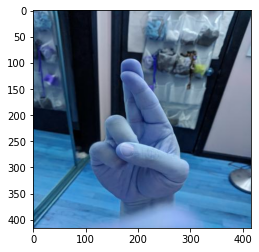

Prediction time: 2.4410040378570557 seconds
Instructions for updating:
Use `tf.cast` instead.
Detection elapsed time: 2.46799898147583 seconds


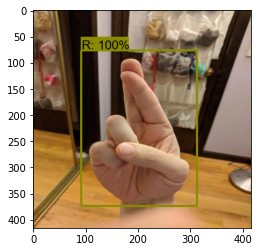

In [3]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import time


# -- Now lets load pipeline config and build a model for detection
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# -- Load the checkpoints we have saved
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-54')).expect_partial()


import cv2
import numpy as np
from matplotlib import pyplot as plt
#matplotlib.use('module://backend_interagg')
%matplotlib inline

# --  define the function
#@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    start_pred_time = time.time()
    prediction_dict = detection_model.predict(image, shapes)
    print('Prediction time:', time.time()-start_pred_time, 'seconds')
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'extra_tests', 'R18_jpg.rf.362d9bbd88ac7b5122cf730d25b36517.jpg')

img = cv2.imread(IMAGE_PATH)
plt.imshow(img)
plt.show()

"""
# -- where working with grayscale images
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.subplots()
plt.imshow(img_gray, cmap='gray')
plt.show()

# -- Convert to RGB with 3 channels
img_rgb = cv2.cvtColor(img_gray,cv2.COLOR_GRAY2RGB)
plt.subplots()
plt.imshow(img_rgb, cmap='gray')
plt.show()
"""

image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
start_detect_time = time.time()
detections = detect_fn(input_tensor)
print('Detection elapsed time:', time.time()-start_detect_time, 'seconds')

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.subplots()
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

#plt.isinteractive()
#plt.interactive(False)
#plt.show(block=True)

# Real Time

In [3]:
# -- Real time detection -----------------------------------------------------------------------------------------------
# -- this use your video camera
#!pip uninstall opencv-python-headless -y
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import time

# -- Now lets load pipeline config and build a model for detection
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# -- Load the checkpoints we have saved
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-54')).expect_partial()

def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    # start_pred_time = time.time()
    prediction_dict = detection_model.predict(image, shapes)
    # print('Prediction time:', time.time()-start_pred_time, 'seconds')
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

cap = cv2.VideoCapture(0) # try other channels if "0" did not worked, line "1" or "2" !!!!!!!!!!!!!!!
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    frame_start_time = time.time()
    ret, frame = cap.read()
    image_np = np.array(frame)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=.8,
        agnostic_mode=False)
    image_np_resized = cv2.resize(image_np_with_detections, (800, 600))
    
    frame_elapsed_time =  time.time() - frame_start_time
    # Put model name and fps text-------------------------------------------
    font             = cv2.FONT_HERSHEY_SIMPLEX
    upperLeftCorner  = (30,35)
    fontScale        = 0.85
    fontColor        = (0,0,255)
    lineType         = 2

    cv2.putText(image_np_resized,'centernet_resnet50_512x512', 
        upperLeftCorner, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(image_np_resized,f'FPS: {np.round(1/frame_elapsed_time, 1)}', 
        (650, 35), # upper right corner 
        font, 
        fontScale,
        fontColor,
        lineType)
    

    cv2.imshow('object detection', image_np_resized) # was (800, 600)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

Instructions for updating:
Use `tf.cast` instead.
